<a href="https://colab.research.google.com/github/timpara/qf_lecture/blob/main/00_Lecture_Integration_Cointegration_and_Stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integration, Cointegration, and Stationarity


In [ ]:
#%sh
!pip install  simfin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 418.2 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt




## The Importance of Testing for Stationarity in Time Series Data

When analyzing time series, researchers often fail to verify the critical assumption that the data are stationary - that is, the properties of the underlying process remain constant over time. To illustrate this concept, consider two hypothetical time series. The first, Series A, is produced by a stationary process characterized by unchanging parameters. In contrast, the data generating process for Series B has parameters that vary with time, making it non-stationar

### Time Series A

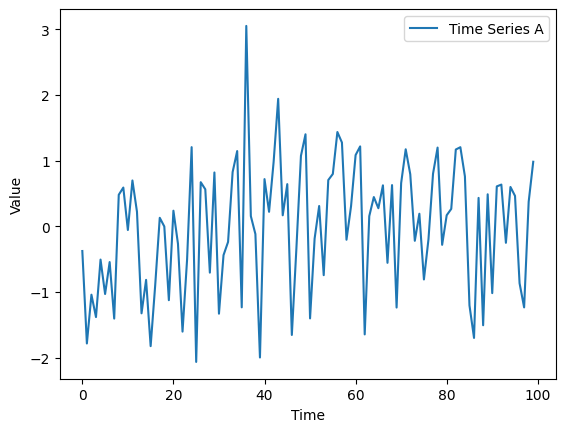

In [ ]:
# Set the parameters and the number of datapoints

mu=0
sigma=1
T = 100

A = pd.Series(index=range(T), dtype='float64')
A.name = 'A'

for t in range(T):
    A[t] = np.random.normal(mu, sigma)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Time Series A']);

### Time Series B

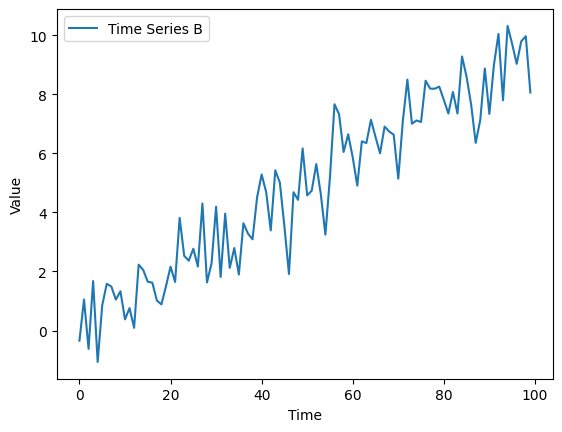

In [ ]:
# Set the number of datapoints
T = 100

B = pd.Series(index=range(T), dtype="float64")
B.name = 'B'
sigma=1
for t in range(T):
    # pay close attention how mu of the underlying process is evolving across time
    mu = t * 0.1
    B[t] = np.random.normal(mu,sigma)

plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Time Series B']);

### The Perils of Ignoring Non-Stationarity in Time Series Data

Many common statistical methods and tests have an implicit assumption, often buried in the technical details, that the data being analyzed is stationary - that is, the statistical properties like mean and variance remain constant over time. If this assumption is violated and non-stationary data is naively fed into these methods, the results obtained can be completely misleading and unreliable. To illustrate, consider the simple case of calculating the mean of a non-stationary time series. The resulting average will incorporate data points from different time periods that may have very different distributions. This aggregate mean is essentially meaningless - it does not represent the typical behavior at any specific point in time, and is useless for predicting future values.

The mean is distorted by the changing properties of the non-stationary series. While this example demonstrates the issue in a obvious way, non-stationarity can cause much more subtle and hard to detect problems when applying statistical models in practice. Ignoring or failing to account for non-constant means, variances, and other properties can invalidate model assumptions and lead analysis badly astray. Stationarity should not be dismissed, as it is a crucial property to assess and handle appropriately when working with time series data.

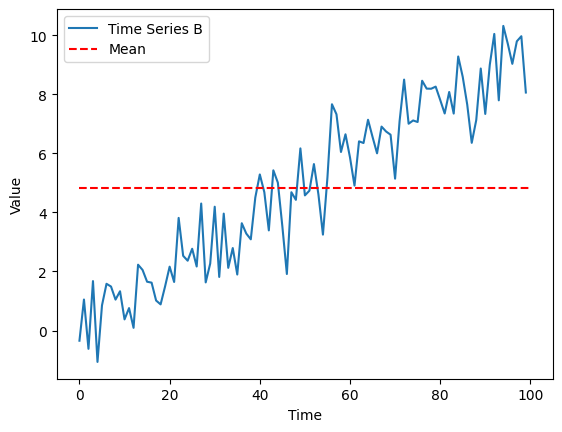

In [ ]:
m = np.mean(B)

plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Time Series B', 'Mean']);

### Testing for Stationarity




In [ ]:
def adfuller_staionarity_test(X, cutoff=0.01):
    """
    The ADF test tests the null hypothesis that a unit root is present in the time series,
    indicating that the series is non-stationary. If the p-value is less than the cutoff (default 0.01),
    we reject the null hypothesis and conclude that the series is likely stationary.

    Parameters:
    -----------
    X : pandas Series
        The time series to be tested for stationarity.
    cutoff : float, optional (default=0.01)
        The significance level for the ADF test. If the p-value is less than this cutoff,
        the series is considered stationary.

    Returns:
    --------
    bool
        True if the series is likely stationary, False otherwise.

    Notes:
    ------
    - The ADF test is a statistical test used to determine if a time series is stationary or not.
    - The null hypothesis of the ADF test is that a unit root is present (i.e., the series is non-stationary).
    - A small p-value (typically < 0.05) indicates strong evidence against the null hypothesis, suggesting stationarity.

    """

    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely to be stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely to be non-stationary.')
        return False

In [ ]:
adfuller_staionarity_test(A);
adfuller_staionarity_test(B);

p-value = 1.1498785225495591e-15 The series A is likely to be stationary.
p-value = 0.9380131746047076 The series B is likely to be non-stationary.


Let's have a look at another example

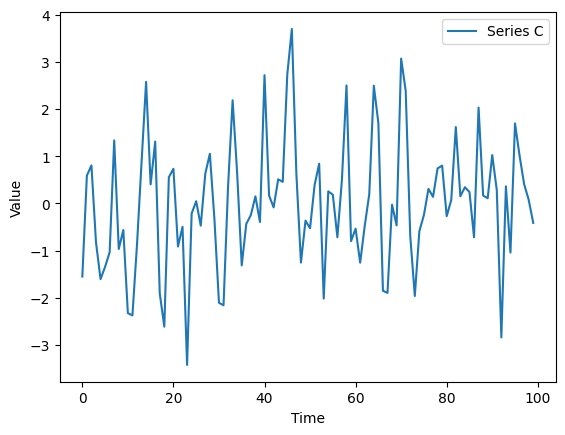

In [ ]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T), dtype="float64")
C.name = 'C'

for t in range(T):
    # pay close attention how mu of the underlying process is evolving across time
    mu = np.sin(t)
    sigma=1
    C[t] = np.random.normal(mu,sigma)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);

Distinguishing between a cyclical variation in the mean and random fluctuations can be quite challenging, especially when working with real-world data that contains noise and has a limited number of observations. In such scenarios, it becomes difficult to confidently determine whether a time series is truly stationary or if any apparent drift in the data is simply due to random noise rather than being part of a genuine trend. Statistical tests for stationarity may struggle to consistently detect these subtle differences, leading to ambiguous results that can vary from case to case.

In [ ]:
adfuller_staionarity_test(C);

p-value = 0.018103586493099916 The series C is likely to be non-stationary.


## The Concept of Integration Order in Time Series Analysis

### Wold's Decomposition Theorem and the Moving Average Representation

A fundamental result in time series analysis is Wold's decomposition theorem, which states that any covariance-stationary time series $Y_t$ can be expressed as the sum of a deterministic component $\eta_t$ and an infinite moving average of an uncorrelated "innovation" process $\epsilon_t$:

$$Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t$$

where:
- $\epsilon_t$ represents the new information or "shock" that enters the system at each time $t$. It is defined as the difference between the actual value $Y_t$ and the optimal forecast $\hat{Y}_t$ based on information available up to time $t-1$.
- The coefficients $b_j$ are the weights that determine how past innovations impact the current value of the series.
- $\eta_t$ captures any purely deterministic patterns like sinusoidal trends that could be modeled exactly.

The innovation term introduces the stochastic, unpredictable element that prevents $Y_t$ from being perfectly forecastable, even given its entire past history.

### Defining the Order of Integration

A time series $$Y_t$$ is said to be integrated of order zero, denoted $$I(0)$$, if the moving average coefficients in its Wold representation satisfy:

$$\sum_{j=0}^\infty |b_j|^2 < \infty$$

Intuitively, this summability condition requires that the influence of past shocks dies out sufficiently fast, so that the series does not stray too far from its mean over time.

Importantly, while stationarity implies $I(0)$, the converse is not true - a non-stationary series can still be $I(0)$. Thus, $$I(0)$$ is a necessary but not sufficient condition for stationarity.

### Testing for $I(0)$ in Practice

In empirical work with finite samples, directly verifying the $$I(0)$$ summability condition is generally not feasible. Instead, most tests for $$I(0)$$ rely on the fact that stationarity is a stronger property that implies $I(0)$. Therefore, if stationarity can be established through other means like unit root tests, then the series is automatically classified as $I(0)$ as well.

For more details on integration order and its relationship to stationarity, these references are helpful:
- Order of integration
- Wold's theorem

Citations:
https://faculty.washington.edu/ezivot/econ584/notes/unitroot.pdf


Let's get back to our stationary time series A. Because A is stationary, it is safe to assume that it's also $I(0)$.

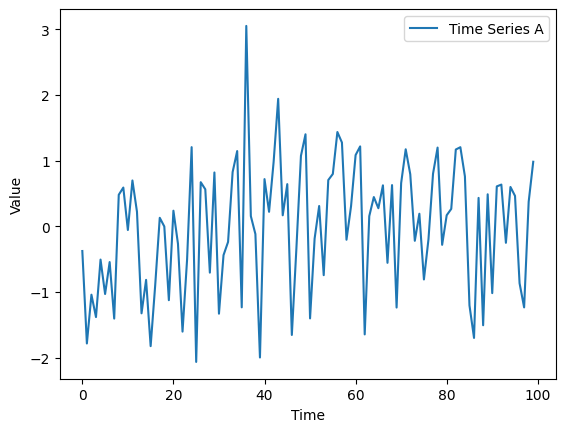

In [ ]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Time Series A']);

### Constructing Higher Order Integrated Series from $I(0)$ Processes

The order of integration of a time series can be increased by repeatedly applying the cumulative summation operation, which is analogous to discrete integration in calculus. Specifically, if we start with an $I(0)$ series and compute its cumulative sum (i.e., the running total of all values up to each time point), the resulting series will be integrated of order one, or $I(1)$.

This process can be iterated to generate series with arbitrarily high orders of integration: to construct an $I(n)$ series, we simply take an $I(0)$ series and cumulatively sum it $n$ times in succession. Mathematically, if $\{X_t\}$ is $I(0)$, then the series $\{Y_t\}$ defined by:

$$Y_t = \sum_{i=1}^t X_i$$

will be $I(1)$. Applying the same summation to $\{Y_t\}$ will yield an $I(2)$ series, and so on. In this way, any integrated series can be built up recursively from a "base" $I(0)$ process through repeated cumulative summation.



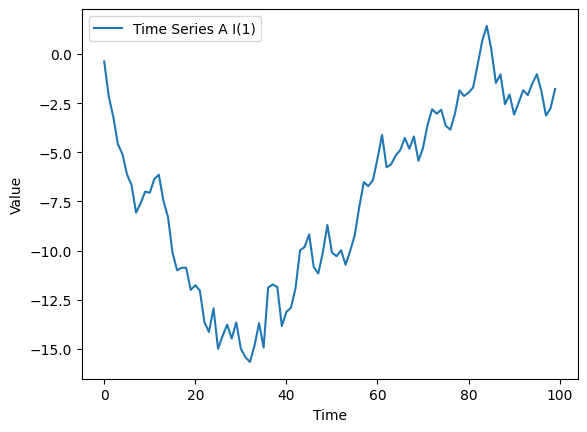

In [ ]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Time Series A I(1)']);

Now let's make one $I(2)$ by taking the cumlulative sum again.

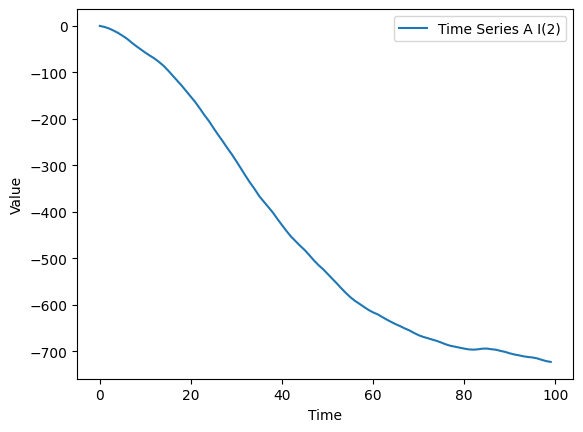

In [ ]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Time Series A I(2)']);


### Determining the Order of Integration through Differencing

To identify the order of integration of a given time series, we can apply the differencing operator $\Delta$, which is the inverse operation of the cumulative sum. The first difference of a series $$X_t$$ is defined as:

$$(1-L)X_t = X_t - X_{t-1} = \Delta X_t$$

where $L$ is the lag or backshift operator. $L$ shifts the index of the time series back by one period, so that $LX_t = X_{t-1}$. The $d$-th difference of $X_t$ can be expressed using the lag operator as:

$$(1-L)^d X_t$$

A time series $Y_t$ is said to be integrated of order one, denoted $I(1)$, if the first difference $(1-L)Y_t = \Delta Y_t$ is a stationary $I(0)$ process. Conversely, taking the cumulative sum of an $I(0)$ series will yield an $I(1)$ series.

### Key Takeaway

The most important point to remember is that any stationary time series is integrated of order zero, or $I(0)$. The order of integration summarizes the number of times a series needs to be differenced to achieve stationarity, which is a crucial property for many time series analysis techniques.



The core ideas conveyed are:

1) Differencing a series (the inverse of cumulative summation) allows us to determine its order of integration

2) The lag operator L is used to concisely express the differencing operation

3) A series is I(1) if its first difference is I(0)

4) Stationarity is equivalent to I(0), and the order of integration counts the differences needed for stationarity


Citations:
https://citeseerx.ist.psu.edu/document?doi=bd4c3482e30cbbbd81174006cb142b314331b5cb&repid=rep1&type=pdf


## Empirical Data
We apply now the previously introduced concepts to empirical equity data

In [ ]:
import simfin as sf
from google.colab import userdata
sf.set_data_dir()
from simfin.names import *
import os

#sf.set_api_key(os.environ.get("SIMFIN_API_KEY"))
sf.set_api_key(userdata.get('SIMFIN_API_KEY'))
df_prices = sf.load_shareprices(market='us', variant='daily')


Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... 

/usr/local/lib/python3.10/dist-packages/simfin/load.py:154: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(path, sep=';', header=0,


Done!


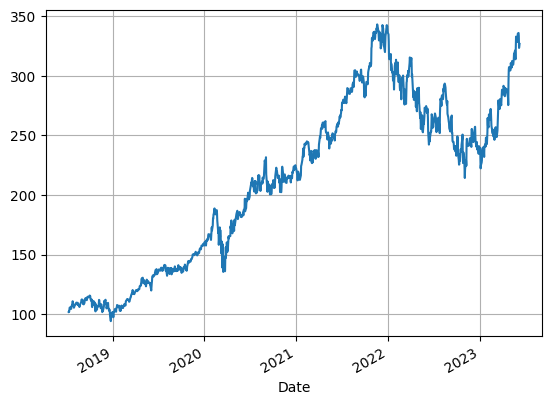

In [ ]:
MSFT=df_prices.loc['MSFT'][CLOSE]
MSFT.plot(grid=True)
X=MSFT

In [ ]:
adfuller_staionarity_test(X)

p-value = 0.8209020416586543 The series Close is likely to be non-stationary.


False

Let's take a look, certainly has the warning signs of a non-stationary series.

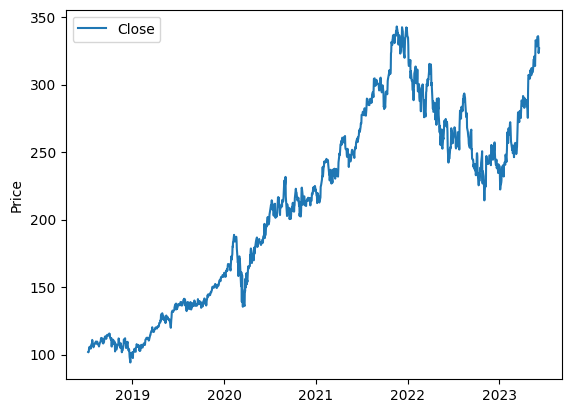

In [ ]:
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend([X.name]);

The statistically trained eye identifies the order of intergration as ....

p-value = 2.5129440464455534e-21 The series Close Additive Returns is likely to be stationary.


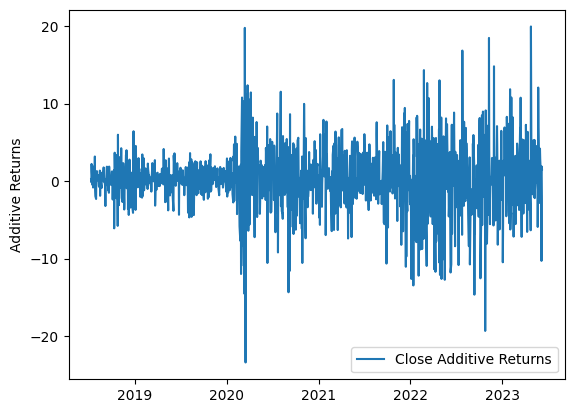

In [ ]:
X1 = X.diff()[1:]
X1.name = X.name + ' Additive Returns'
adfuller_staionarity_test(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend([X1.name]);

Seems like the additive returns are stationary over 2010. That means we will probably be able to model the returns much better than the price. It also means that the price was $I(1)$.

Let's also check the multiplicative returns.

p-value = 1.426591660581475e-21 The series Close Multiplicative Returns is likely to be stationary.


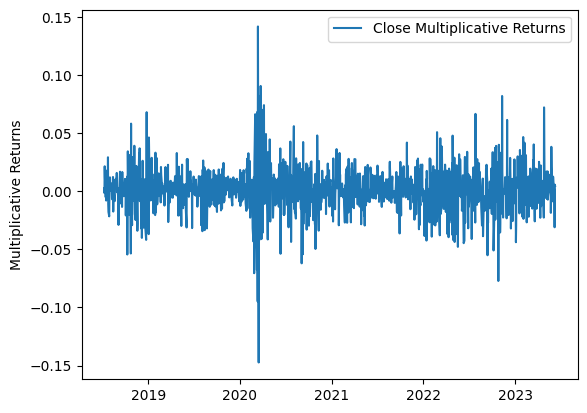

In [ ]:
X1 = X.pct_change()[1:]
X1.name = X.name + ' Multiplicative Returns'
adfuller_staionarity_test(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X1.name]);

The multiplicative returns of the series appear to exhibit stationarity, similar to the additive differences. This is not surprising, as both transformations capture related aspects of the series' dynamics. However, it's important to note that this may not always hold true for every dataset.

## Crucial Consideration

It is essential to exercise caution when assuming that a time series will maintain its stationarity in the future based solely on its past behavior. To assess the robustness and consistency of stationarity, it is necessary to employ techniques such as cross-validation and out-of-sample testing. This principle applies to any statistical property, but it bears repeating in the context of stationarity. Moreover, it is possible for a time series to transition between stationary and non-stationary regimes over time. The presence or absence of stationarity may also depend on factors such as the chosen timeframe and the frequency at which the data is sampled. Therefore, it is crucial to continually monitor and reassess the stationarity of a series as new data becomes available.

## The Importance of Returns in Quantitative Financial Modeling
In the field of quantitative finance, returns are often preferred over prices as the primary variable for modeling and forecasting. This preference stems from the fact that returns typically exhibit much stronger stationarity properties compared to prices. The stationarity of returns makes them more amenable to statistical modeling techniques, as the underlying assumptions of many models, such as constant mean and variance, are more likely to hold. Consequently, forecasting returns tends to be more feasible and reliable than attempting to predict prices directly. Prices, on the other hand, are often integrated of order one, denoted as I(1). This means that they contain trends and non-stationary behavior, which can complicate the modeling process and reduce the accuracy of price forecasts. Moreover, even if a model successfully forecasts returns, translating those predictions into price forecasts can be challenging.

Any errors in the returns forecast will accumulate and be amplified when compounded over time to obtain price predictions. This can lead to significant discrepancies between the forecasted and actual prices, especially over longer horizons. Therefore, while returns forecasting is not without its difficulties, it is generally considered a more tractable problem than price forecasting in quantitative finance. The stationarity of returns provides a more stable foundation for statistical modeling and helps to mitigate some of the challenges associated with non-stationary price dynamics.

## Understanding Cointegration in Time Series Analysis

With a solid grasp of stationarity and the order of integration, we can now delve into the concept of cointegration, which plays a crucial role in analyzing the long-run relationships between non-stationary time series.

### Linear Combination of Time Series

Before defining cointegration, it is essential to understand the concept of a linear combination. Given a set of time series ($X_1$, $X_2$, $\dots$, $X_k$), a linear combination is a new time series $Y$ constructed by taking a weighted sum of the original series using any set of real numbers $b_1, \dots, b_k$ as coefficients:

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

### Definition of Cointegration

A set of time series ($X_1$, $X_2$, $\dots$, $X_k$) is said to be cointegrated if the following conditions are met:

1. All the series are integrated of order one, denoted as I(1).
2. There exists a linear combination of these series that is integrated of order zero, or I(0).

In other words, cointegration occurs when a linear combination of non-stationary I(1) series results in a stationary I(0) series.

#### Illustrative Example

Consider three time series $X_1$, $X_2$, and $X_3$, all of which are I(1). If the linear combination $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$ is found to be I(0), then the series are said to be cointegrated.

### Intuitive Interpretation

Intuitively, cointegration implies that there exists a long-run equilibrium relationship between the non-stationary series. The linear combination that yields a stationary series represents the deviation from this equilibrium, which is typically characterized by low autocovariance and a tendency to revert to its mean over time.

This property of cointegration is particularly useful in applications such as pairs trading, where the goal is to identify two assets whose prices are cointegrated. By exploiting the mean-reverting behavior of the linear combination $b_1A_1 + b_2A_2$, traders can develop strategies to profit from temporary deviations from the long-run equilibrium.


The core ideas conveyed are:

1) Cointegration involves a linear combination of I(1) series resulting in an I(0) series

2) Cointegration implies a long-run equilibrium relationship between non-stationary series

3) The stationary linear combination represents deviations from the equilibrium

4) Cointegration is useful for applications like pairs trading, which exploits mean reversion



### Simulated Data Example

We briefly return to simulated data to emphasize cointegration

In [ ]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

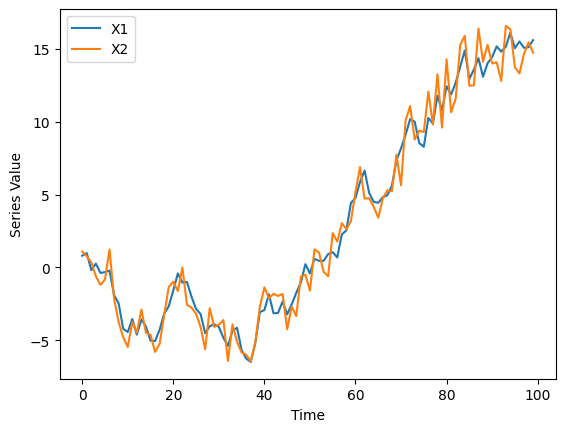

In [ ]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

We constructed $X_2$ as an $I(1)$ series plus some stationary noise. It is safe to assume that $X_2$ is still $I(1)$.


In [ ]:
Z = X2.diff()[1:]
Z.name = 'Z'

adfuller_staionarity_test(Z);

p-value = 3.00131110817458e-11 The series Z is likely to be stationary.


To demonstrate cointegration between the time series $X_1$ and $X_2$, our next step is to identify a linear combination of these series that exhibits stationarity. A natural choice to consider is the difference between the two series, given by $X_2 - X_1$.

If the series are indeed cointegrated, this linear combination should effectively cancel out the common non-stationary components, leaving behind only stationary residuals or noise. The presence of cointegration implies that the two series share a long-run equilibrium relationship, and the stationary linear combination captures the deviations from this equilibrium.

To verify our hypothesis, we will proceed to analyze the stationarity properties of the series $X_2 - X_1$. If this difference series is found to be stationary, it will provide strong evidence in support of the cointegration between $X_1$ and $X_2$.

p-value = 3.0878068600271224e-18 The series Z is likely to be stationary.


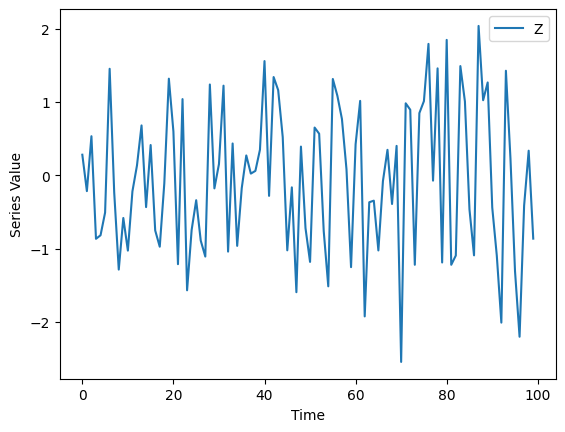

In [ ]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z']);

adfuller_staionarity_test(Z);

### Approaches to Testing for Cointegration

Several methods exist for testing whether a set of time series are cointegrated. The general goal is to identify the coefficients $b_1, \dots, b_k$ that produce a stationary linear combination of the series, denoted as $I(0)$. If the most promising candidate set of coefficients fails to yield a combination that passes stationarity tests, we reject the hypothesis of cointegration for that set of series.

This testing approach may lead to Type II errors (false negatives), as not all possible coefficient combinations are exhaustively checked for stationarity. However, Type II errors are generally preferable in this context, as they are conservative and do not result in making incorrect forecasts based on spurious relationships.

A commonly used method for testing cointegration between two time series is the Engle-Granger two-step approach. First, a linear regression is estimated to model the relationship between the series:

$$X_2 = \alpha + \beta X_1 + \epsilon$$

If $X_1$ and $X_2$ are truly cointegrated, then the regression should effectively remove the non-stationary component of $X_2$ that is dependent on $X_1$, leaving only stationary residuals. In other words, the linear combination $X_2 - \beta X_1 = \alpha + \epsilon$ should be $I(0)$.

The second step is to apply stationarity tests, such as the Augmented Dickey-Fuller (ADF) test, to the residuals $\hat{\epsilon}$ from the estimated regression. Rejecting the null hypothesis of a unit root provides evidence in favor of cointegration.

Other cointegration testing procedures, such as the Johansen test, extend this approach to handle multiple time series and allow for more than one cointegrating relationship[4]. These tests rely on examining the rank of the matrix of cointegrating vectors and testing restrictions on the cointegrating relationships and adjustment speeds.

While cointegration tests provide a valuable tool for identifying stable long-run relationships between non-stationary series, care must be taken in interpreting the results. The possibility of Type II errors and the sensitivity of some tests to assumptions like constant cointegrating relationships over time must be considered.



The key ideas conveyed are:
1) Cointegration tests aim to find linear combinations of non-stationary series that are stationary
2) Type II errors are possible but preferable to making false assumptions of cointegration
3) The Engle-Granger method tests cointegration between two series by assessing residual stationarity
4) Other tests like Johansen's extend to multiple series and cointegrating relations
5) Care is needed in interpreting test results given potential issues like structural changes over time




### Empirical Data



In [ ]:

X1 = df_prices.loc['MSFT'][CLOSE]
X2 = df_prices.loc['AAPL'][CLOSE]

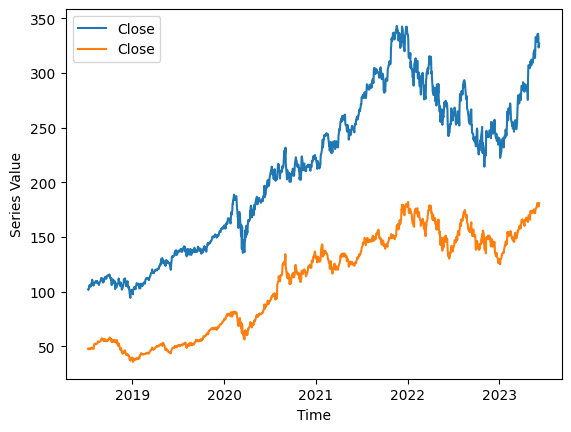

In [ ]:
plt.plot(X1.index, X1.values)
plt.plot(X1.index, X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

Now use linear regression to compute $\beta$.

In [ ]:
import statsmodels.api as sm
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()

# Remove constant column
X1 = X1['Close']

results.params

const   -23.648202
Close     0.626625
dtype: float64

p-value = 0.12105793509488716 The series Z is likely to be non-stationary.


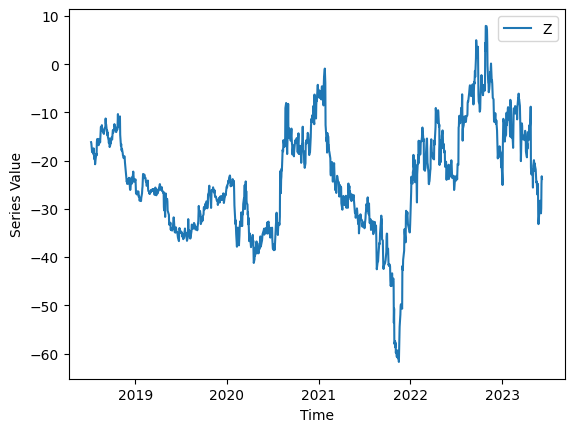

In [ ]:
b = results.params['Close']
Z = X2 - b * X1
Z.name = 'Z'

plt.plot(Z.index, Z.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([Z.name]);

adfuller_staionarity_test(Z);

We can see here that the resulting $Z$ was likely non-stationary over the time frame we looked at. This causes us to reject the hypothesis that our two assets were cointegrated over the same timeframe. How to identiy co-integrated time series will be shown in the next lecture.

### Forecasting with Cointegration: Proceed with Caution
It is crucial to recognize that the results of cointegration tests are based on historical data and do not guarantee future relationships. Just because a set of assets has exhibited cointegration in the past does not necessarily imply that they will remain cointegrated going forward. To mitigate this risk, it is essential to continuously monitor and validate the consistency of the cointegrating relationship over time. This involves applying various model validation techniques, such as out-of-sample testing and rolling window analysis, to assess the stability and robustness of the cointegration model.
### Diversification: A Key Principle in Cointegration-Based Strategies
One of the fundamental principles in quantitative finance is to spread risk by making multiple independent bets. In the context of cointegration-based strategies, such as pairs trading, this translates to identifying a diverse set of asset pairs that are hypothesized to be cointegrated. Rather than concentrating all capital on a single cointegrated pair, a prudent approach is to allocate funds evenly across multiple pairs. By diversifying the portfolio, the overall strategy can still be profitable even if some of the pairs fail to maintain their cointegrating relationship. As long as more than half of the selected asset pairs continue to exhibit cointegration, the diversified strategy has a good chance of success. This approach helps to mitigate the impact of individual pair failures and enhances the robustness of the overall portfolio.

The key ideas conveyed are:

1) Historical cointegration does not guarantee future cointegration, so ongoing validation is crucial

2) Diversification is essential in cointegration-based strategies to spread risk and mitigate pair failures

3) Allocating capital evenly across multiple cointegrated pairs enhances portfolio robustness

4) The Pairs Trading lecture provides more detailed insights into the practical implementation of these strategies
